<a href="https://colab.research.google.com/github/Soy0ungPark/fastcampus_DL/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mini PJT

- 해당 데이터를 고객 단위로 묶어야 합니다.


- 데이터를 정제해서, 월별/고객별로 재정렬이 필요합니다. (aggregation)


- row가 고객별 데이터로 묶이고 난 다음, 고객들을 유형별로 나눠봅니다.


- 여러 가지 클러스터링 알고리즘을 사용하여, 결과를 테스트해봅니다.


- 클러스터링을 위한 전처리부터, 평가까지 모든 항목을 하나하나 살펴보면서 데이터를 뜯어봅니다.

### Data Description

Source : https://www.kaggle.com/c/instacart-market-basket-analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. 데이터 불러오기 

In [2]:
# instacart 데이터를 모두 불러옵니다.
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

base_path = '/content/drive/MyDrive/MLDL/FastCampus/instacart-market-basket-analysis/'
aisles = pd.read_csv(base_path + 'aisles.csv')
departments = pd.read_csv(base_path + 'departments.csv')
prior = pd.read_csv(base_path + 'order_products__prior.csv')
train = pd.read_csv(base_path + 'order_products__train.csv')
orders = pd.read_csv(base_path + 'orders.csv')
products = pd.read_csv(base_path + 'products.csv')


In [5]:
prior_sample = prior[:10000]
prior_sample

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
9995,1022,21903,1,1
9996,1022,38689,2,1
9997,1022,30391,3,1
9998,1022,18670,4,1


In [ ]:
print(aisles.shape, departments.shape, prior.shape, train.shape, orders.shape, products.shape)

(134, 2) (21, 2) (32434489, 4) (1384617, 4) (3421083, 7) (49688, 4)


In [ ]:
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [ ]:
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [ ]:
prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [ ]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [ ]:
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [9]:
# 불러온 모든 테이블을 합칩니다.
temp = pd.merge(orders, prior_sample, on='order_id')
temp = pd.merge(temp, products, on='product_id')
temp = pd.merge(temp, aisles, on='aisle_id')
temp = pd.merge(temp, departments, on='department_id')
temp

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,40,382,prior,29,1,15,23.0,10070,1,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
1,235,58701,prior,20,5,9,9.0,10070,7,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
2,581,76141,prior,3,6,17,7.0,10070,3,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
3,649,135836,prior,1,4,7,NaN,10070,1,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
4,40,382,prior,29,1,15,23.0,34866,4,1,Chocolate Milk 1% Milkfat,84,16,milk,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,152,103040,prior,12,1,10,7.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9996,959,119941,prior,2,6,13,21.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9997,400,180454,prior,32,0,8,8.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9998,18,118860,prior,3,4,20,6.0,1000,3,0,Apricots,18,10,bulk dried fruits vegetables,bulk


### 2. EDA

In [15]:
# 1만개의 거래내역에 대해서 각 물품을 얼마나 샀을까?
#temp.user_id.value_counts() # 972명의 고객 - 기간내 구매 내역 중 N개의 product 구매
#temp.product_name.value_counts()
#temp.aisle.value_counts()
#temp.department.value_counts()
#temp.order_dow.value_counts()
temp.order_hour_of_day.value_counts()

12    903
13    821
9     818
16    815
10    813
11    793
15    775
17    771
14    706
8     601
18    546
20    373
19    335
7     231
22    175
21    172
23    134
6      95
0      76
1      26
4      16
2       5
Name: order_hour_of_day, dtype: int64

### 3. 데이터 전처리

- 데이터를 transaction 단위로 변경합니다.

- 각자의 방법대로 데이터의 단위를 정해봅시다.


> User 단위로 어떤 물품을 구매했는지의 정보만 가지는 feature vector로 변환한다. e.g. pd.crosstab, CountVectorizer

In [16]:
# transaction --> user level 단위로 변경하고, User당 정보로 변환하는 과정까지 마무리합니다.
# 1. Department # 2. aisle # 3. product_name 

X = pd.crosstab(index=temp.user_id, columns=temp.department)
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


### 4. 클러스터링 모델 적용하기

- 사용하는 클러스터링 모델은 KMeans로 합니다.

(원하시면 AgglomerativeClustering, DBSCAN, SpectralClustering을 사용해보셔도 됩니다. 단, 시간이 매우매우 오래 걸릴수 있으니 주의하세요..)

**[K-Means]**

- Elbow method를 이용하여 최적의 K값을 찾아보세요.


- sparse한 특징을 가지는 데이터를 클러스터링 하기 위해서는 어떤 기법을 사용해야 할까요?


- 클러스터링 결과를 시각화해보고, 실루엣 지수도 계산해봅시다.

In [17]:
# data setting
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
# tSNE : 시각화용도의 차원감소 기법. (2차원으로 변환해주는 기법)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)
tsne_data

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[ 12.164216 , -19.2596   ],
       [ 24.660084 ,   9.523865 ],
       [ 19.791985 ,  -8.40317  ],
       ...,
       [  6.968423 ,  -8.183741 ],
       [ 15.547837 , -14.911605 ],
       [-12.8091545,  -2.6987567]], dtype=float32)

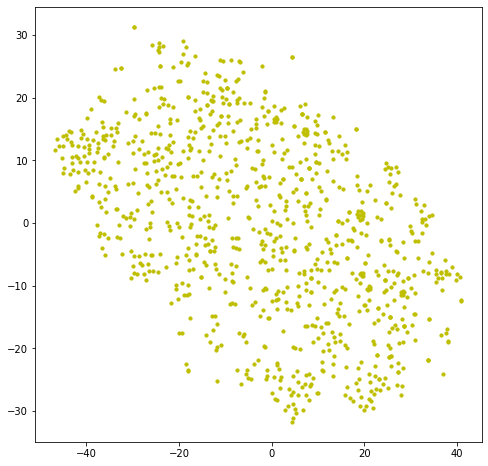

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c='y')
plt.show()

In [30]:
# K-means를 돌려봅시다.
from sklearn.cluster import KMeans # 1. K-means
from sklearn.cluster import AgglomerativeClustering # 2. Hierarchical Aggolomerative Clustering
from sklearn.cluster import DBSCAN # 3. DBSCAN
from sklearn.cluster import SpectralClustering # 4. Spectral Clustering 

from sklearn.metrics import silhouette_score

model = KMeans(n_clusters=4)
model2 = KMeans(n_clusters=2)
#model.fit(X) #unsupervised setting
pred = model.fit_predict(X)
pred2 = model2.fit_predict(X)
pred

print('Silhouette Score : %.4f' % silhouette_score(X, pred))
print('Silhouette Score : %.4f' % silhouette_score(X, pred2))

Silhouette Score : 0.1895
Silhouette Score : 0.3641


In [27]:
# elbow method
sse = []
silhouettes = []

for K in range(2,11):
  model = KMeans(n_clusters=K) # K : 2 - 10
  pred = model.fit_predict(X)
  sse.append(model.inertia_) # SSE
  silhouettes.append(silhouette_score(X, pred))

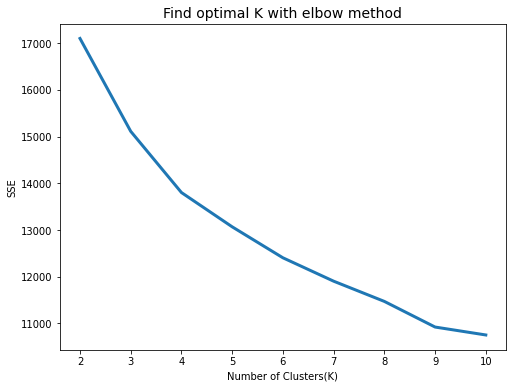

In [28]:
# 최적의 K는 어떻게 구할까요?
# Elbow method : 정해진 K에 대해서 SSE를 계산한 다음, SSE가 가장 많이 꺾이는 K(elbow)가 optimal K라고 판단하는 방법.

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with elbow method", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("SSE", fontsize=10)
plt.plot(range(2,11), sse, lw=3)
plt.show()

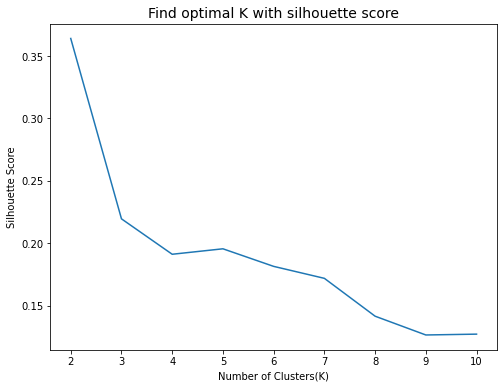

In [29]:
# Silhouette score : 같은 클러스터에 속하는 데이터중 가장 먼 데이터와의 거리와 다른 클러스터에 속하는 데이터 중 가장 가까운 데이터와의 거리 비율을 계산한 지표. [-1, 1]
# Reference : https://en.wikipedia.org/wiki/Silhouette_(clustering)

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with silhouette score", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.plot(range(2, 11), silhouettes)
plt.show()

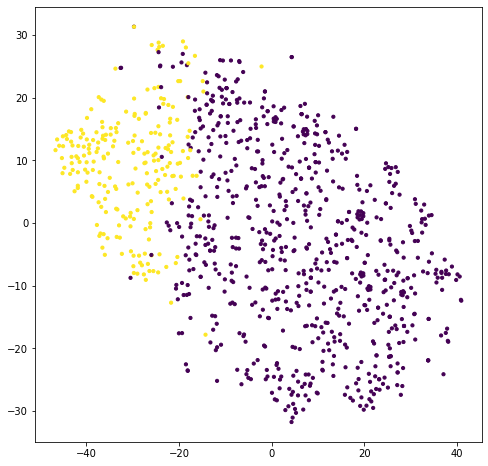

In [33]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c=pred2, cmap="viridis") #prediction 결과에 색을 넣어줌 
plt.show()

In [42]:
# see summary
X['cluster_label'] = pred2
X['Cluster_label'] = pred
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,missing,other,pantry,personal care,pets,produce,snacks,cluster label,cluster_label,Cluster_label
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,3
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,2,0,0,0,3
971,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,3
1059,0,0,3,0,3,0,0,8,0,0,...,0,0,2,0,0,8,2,1,1,1
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,2,2,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,4,1,0,0,2
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,1,0,0,0,3


In [43]:
group1 = X.loc[X.cluster_label == 0, :]
group2 = X.loc[X.cluster_label == 1, :]
group3 = X.loc[X.Cluster_label == 0, :]
group4 = X.loc[X.Cluster_label == 1, :]
print(group1.shape, group2.shape, group3.shape, group4.shape)

#실제와 실루엣 계수의 결과가 동일하지 않을수도 있음 

(750, 24) (222, 24) (146, 24) (92, 24)


In [44]:
group1.mean() # top3 : product, dairy eggs, snacks

department
alcohol            0.033333
babies             0.105333
bakery             0.297333
beverages          0.776000
breakfast          0.201333
bulk               0.002667
canned goods       0.282667
dairy eggs         1.273333
deli               0.241333
dry goods pasta    0.202667
frozen             0.653333
household          0.252000
international      0.073333
meat seafood       0.166667
missing            0.014667
other              0.016000
pantry             0.512000
personal care      0.129333
pets               0.026667
produce            1.668000
snacks             0.728000
cluster label      0.000000
cluster_label      0.000000
Cluster_label      2.338667
dtype: float64

In [45]:
group2.mean() #top3 : product, dairy eggs, beverage

department
alcohol            0.009009
babies             0.234234
bakery             0.590090
beverages          0.986486
breakfast          0.391892
bulk               0.018018
canned goods       0.675676
dairy eggs         3.117117
deli               0.621622
dry goods pasta    0.463964
frozen             1.153153
household          0.270270
international      0.139640
meat seafood       0.450450
missing            0.018018
other              0.004505
pantry             0.963964
personal care      0.126126
pets               0.036036
produce            7.486486
snacks             1.423423
cluster label      1.000000
cluster_label      1.000000
Cluster_label      1.207207
dtype: float64

In [46]:
group3.mean()

department
alcohol            0.006849
babies             0.308219
bakery             0.643836
beverages          1.061644
breakfast          0.465753
bulk               0.000000
canned goods       0.493151
dairy eggs         4.335616
deli               0.383562
dry goods pasta    0.561644
frozen             1.472603
household          0.273973
international      0.157534
meat seafood       0.383562
missing            0.041096
other              0.006849
pantry             1.061644
personal care      0.253425
pets               0.047945
produce            2.671233
snacks             1.849315
cluster label      0.287671
cluster_label      0.287671
Cluster_label      0.000000
dtype: float64

In [47]:
group4.mean()

department
alcohol             0.010870
babies              0.239130
bakery              0.630435
beverages           1.336957
breakfast           0.347826
bulk                0.032609
canned goods        0.728261
dairy eggs          3.336957
deli                0.869565
dry goods pasta     0.467391
frozen              1.369565
household           0.358696
international       0.152174
meat seafood        0.369565
missing             0.010870
other               0.000000
pantry              1.000000
personal care       0.097826
pets                0.065217
produce            10.271739
snacks              1.554348
cluster label       1.000000
cluster_label       1.000000
Cluster_label       1.000000
dtype: float64

In [ ]:
# silhouette score with optimal K
